In [1]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import scipy
import math
from tqdm import tqdm
import pickle
from utils.data_loading import load_disruption_distance, load_papers
from utils.figure_plot import plot_odd_ratio_with_colors, plot_difference_histograms

In [2]:
font_path = '../data/font/helvetica.ttf'
font_manager.fontManager.addfont(font_path)

prop = font_manager.FontProperties(family='Helvetica')

# Data Loading

In [3]:
papers_df = load_papers("/data/sg/munjkim/wos/original_1960_2019/paper_table_paper_id_combined_Nov252024.csv")
papers_df.head()

,woscode,year,date,title,journal,doi,author_number,author_name,Pubtype,paper_id
0,WOS:A1960WH28400013,1960,1960-01-01,OSSIFICATION OF THE CORACO-ACROMIAL LIGAMENT,RADIOLOGY,10.1148/74.5.802,2,"['BERENS, DL', 'LOCKIE, LM']",Article,37961841
1,WOS:A1960WW47600008,1960,1960-01-01,CLINICAL AND PATHOLOGIC ASPECTS OF HYDATIDIFOR...,OBSTETRICS AND GYNECOLOGY,NaN,2,"['REINER, I', 'DOUGHERTY, CM']",Article,37999317
2,WOS:A1960CDS2100006,1960,1960-01-01,CHILDREN OF URANUS,PHI DELTA KAPPAN,NaN,1,"['RAFFERTY, M']",Article,37928349
3,WOS:A1960WE64700022,1960,1960-01-01,ELASTIC PROPERTIES OF CERIUM INFLUENCED BY HYD...,DOKLADY AKADEMII NAUK SSSR,NaN,3,"['VORONOV, FF', 'VERESHCHAGIN, LF', 'GONCHAROV...",Article,37954347
4,WOS:A1960WX62700054,1960,1960-01-01,ACTION OF DDT AT AN INSECT SYNAPSE,JOURNAL OF ECONOMIC ENTOMOLOGY,10.1093/jee/53.1.170,1,"['SMYTH, T']",Note,38000903


In [4]:
net = scipy.sparse.load_npz("/data/sg/munjkim/wos/original_1960_2019/citation_net.npz")

citations = np.array(net.sum(axis=0))[0]
references = np.array(net.sum(axis=1)).reshape((1,-1))[0]

In [5]:
papers_df = papers_df[papers_df['Pubtype'].apply(lambda x: x in {'Article','Review', 'Letter','Proceedings Paper'})]

In [6]:
#citation network

papers_df['citations'] = papers_df['paper_id'].apply(lambda x: citations[x])
papers_df['references'] = papers_df['paper_id'].apply(lambda x: references[x])

In [7]:
papers_df = papers_df[papers_df['citations']>4]
papers_df = papers_df[papers_df['references']>0]
papers_df = papers_df[papers_df['year']<2017]
papers_df = papers_df[papers_df['year']>1962]

In [8]:
NETWORKS_NAME = ['original_1960_2019','original_1960_2019/random1']
MEASURE = ['disruption','disruption_nok','100_5_q_1_ep_1_bs_65536_embedding/distance','disruption_5','100_1_q_1_ep_1_bs_65536_embedding/distance','100_1_q_1_ep_2_bs_65536_embedding/distance','100_5_q_1_ep_2_bs_65536_embedding/distance']


for net in tqdm(NETWORKS_NAME):
    for m in MEASURE:
        papers_df = load_disruption_distance(papers_df,net,m)

 50%|███████████████████████████████████████████████████████████▌                                                           | 1/2 [01:16<01:16, 76.68s/it]

no such directory: /data/sg/munjkim/wos/original_1960_2019/random1/disruption_nok.npy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:24<00:00, 72.07s/it]


# Nobel Prize

In [9]:
nobel_prize = pd.read_csv('../data/raw/Prize-winning paper record.tab',sep='\t') # Nobel prize reference 2

In [10]:
nobel_prize_2 = pd.read_csv('../data/raw/Nobel_prize_doi_cleaned.csv',sep=',', encoding= 'unicode_escape')

In [11]:
nobel_prize_set = set(nobel_prize['Paper ID'].apply(lambda x: int(x) if not math.isnan(x) else x))

In [12]:
with open('/data/sg/munjkim/wos/WOS2MAG.pickle', 'rb') as f:
    WOS2MAG = pickle.load(f)

In [13]:
nobel_prize_df = papers_df[papers_df['woscode'].apply(lambda x: WOS2MAG[x] in nobel_prize_set if x in WOS2MAG else False)]

In [14]:
nobel_prize_2_doi = set(nobel_prize_2['doi'])

In [15]:
nobel_prize_df_2 = papers_df[papers_df['doi'].apply(lambda x: x in nobel_prize_2_doi)]

In [16]:
nobel_prize_df  = pd.concat([nobel_prize_df, nobel_prize_df_2]).drop_duplicates(subset = ['woscode'])

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_206743/1766438445.py:14: SyntaxWarning: invalid escape sequence '\D'
  xlabel='Quantile of $\Delta$',


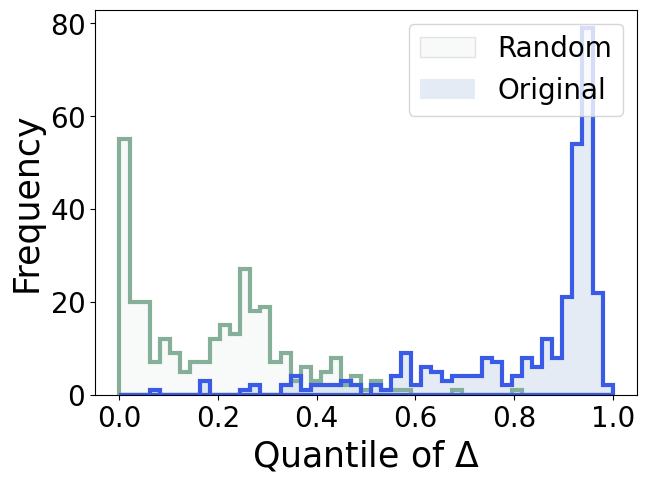

In [17]:
bins = np.linspace(0, 1,50)

plot_difference_histograms(
    dataframe=nobel_prize_df,
    column1='PCNT_RANK_original_1960_2019/random1_100_5_q_1_ep_1_bs_65536_embedding_distance',
    column2='PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance',
    bins=bins,
    label1='Random',
    label2='Original',
    color1='#b3d4c1',
    color2='#00429d',
    edgecolor1='#86af99',
    edgecolor2='#395be6',
    xlabel='Quantile of $\Delta$',
    ylabel='Frequency',
    figsize=(7, 5),
   output_path='../results/Figures/Figure3b_WOS_Nobel_EDM_Distribution.png'
)


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_206743/3218767621.py:10: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ Percentile',size=25)


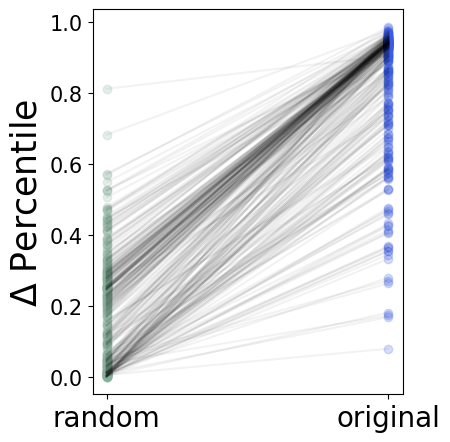

In [18]:
plt.figure(figsize = (4,5))

for i in range(len(nobel_prize_df)):
    plt.plot([0,1],[nobel_prize_df['PCNT_RANK_original_1960_2019/random1_100_5_q_1_ep_1_bs_65536_embedding_distance'].iloc[i], nobel_prize_df['PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance'].iloc[i]], alpha=0.05,color='black')
plt.scatter([0]*len(nobel_prize_df),nobel_prize_df['PCNT_RANK_original_1960_2019/random1_100_5_q_1_ep_1_bs_65536_embedding_distance'],color=  '#86af99',alpha=0.2)
# plt.xlim([0,1])
plt.scatter([1]*len(nobel_prize_df),nobel_prize_df['PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance'],color = '#395be6',alpha=0.2)
plt.xticks([0,1], ['random','original'],size=20)
plt.yticks(size=15)
plt.ylabel('$\Delta$ Percentile',size=25)
plt.savefig('../results/Figures/Figure3c_WOS_Nobel_EDM_Distribution_Compare.png', bbox_inches = 'tight')
plt.show()

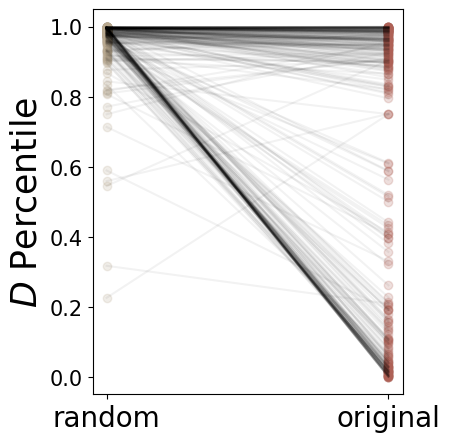

In [19]:
plt.figure(figsize = (4,5))

for i in range(len(nobel_prize_df)):
    plt.plot([0,1],[nobel_prize_df['PCNT_RANK_original_1960_2019/random1_disruption'].iloc[i], nobel_prize_df['PCNT_RANK_original_1960_2019_disruption'].iloc[i]], alpha=0.05,color='black')

    
plt.scatter([0]*len(nobel_prize_df),nobel_prize_df['PCNT_RANK_original_1960_2019/random1_disruption'],color='#b8a88f',alpha=0.2)
# plt.xlim([0,1])
plt.scatter([1]*len(nobel_prize_df),nobel_prize_df['PCNT_RANK_original_1960_2019_disruption'],color= '#AE6156',alpha=0.2)
plt.xticks([0,1], ['random','original'],size=20)
plt.yticks(size=15)

plt.ylabel('$D$ Percentile',size=25)

plt.savefig('../results/Figures/Figure3c_WOS_Nobel_D_Distribution_Compare.png', bbox_inches = 'tight')

<>:18: SyntaxWarning: invalid escape sequence '\D'
<>:18: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_206743/1520485714.py:18: SyntaxWarning: invalid escape sequence '\D'
  xlabel='Quantile of $\Delta$',


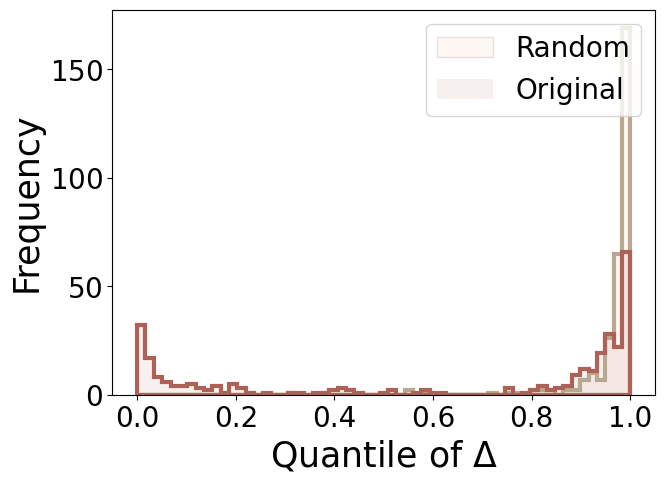

In [21]:
bins = np.linspace(0, 1, 60)
original_color = '#A96D61'
original_color2 = '#802c7f'
original_line_color2 = '#795e68'
original_line_color = '#AE6156'

plot_difference_histograms(
    dataframe=nobel_prize_df,
    column1='PCNT_RANK_original_1960_2019/random1_disruption',
    column2='PCNT_RANK_original_1960_2019_disruption',
    bins=bins,
    label1='Random',
    label2='Original',
    color1='#fab48a',
    color2=original_color,
    edgecolor1='#b8a88f',
    edgecolor2=original_line_color,
    xlabel='Quantile of $\Delta$',
    ylabel='Frequency',
    figsize=(7, 5),
    output_path='../results/Figures/Figure3b_WOS_Nobel_D_Distribution.png'
)


# Regression

In [22]:
nobel_prize_df_woscode = set(nobel_prize_df['woscode'])

In [23]:
papers_df['nobel'] = papers_df['woscode'].apply(lambda x: 1 if x in  nobel_prize_df_woscode else 0)

In [59]:
# papers_df[['nobel','original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance',
#            'original_1960_2019_100_1_q_1_ep_1_bs_65536_embedding_distance',
#           'PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance',
#            'PCNT_RANK_original_1960_2019_100_1_q_1_ep_1_bs_65536_embedding_distance',
#           'PCNT_RANK_original_1960_2019_disruption',
#           'original_1960_2019_disruption','citations']].to_csv('../data/derived/Nobel_papers_df_regression.csv',index=False)

See `R_regression.ipynb` for the result of regression

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_206743/498830126.py:1: SyntaxWarning: invalid escape sequence '\D'
  variable_names =  ['D Percentile', '$\Delta$ Percentile','log(citations)']
/home/munjkim/Publishing/embedding-disruptiveness_11252024/embedding-disruptiveness-private/libs/util/utils/figure_plot.py:131: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(-0.10,7.5)


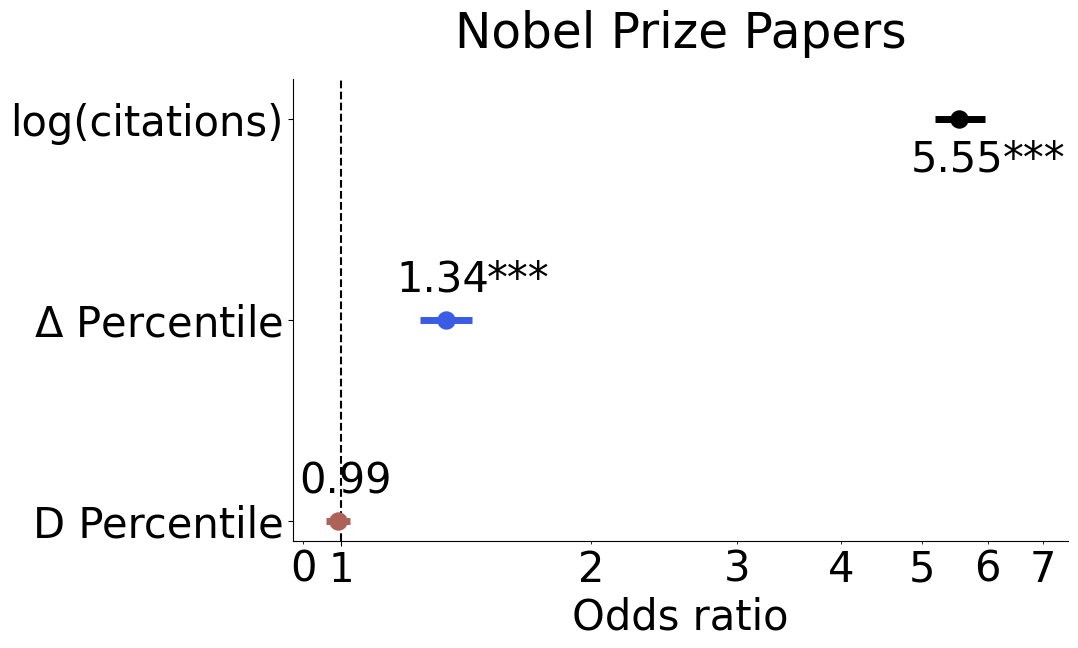

In [25]:


variable_names =  ['D Percentile', '$\Delta$ Percentile','log(citations)']
p_values = np.array([0.1585539, 1.754485e-07, 0.0])


# Extract odds ratios and confidence intervals
odds_ratios = np.exp( np.array( [-0.008427667,  0.289797906, 1.713716564] )  )
upper_limits = np.exp( np.array( [0.02539994,  0.36396140,  1.78363802]))
lower_limits = np.exp(np.array([ -0.04154921, 0.22003752,  1.64506737]))



# Colors for each variable
colors = ['#AE6156', '#395be6', 'black']

# Call the function
plot_odd_ratio_with_colors(
    variable_names=variable_names,
    odds_ratios=odds_ratios,
    lower_limits=lower_limits,
    upper_limits=upper_limits,
    p_values=p_values,figsize=(10, 6), 
    title='Nobel Prize Papers',
    colors=colors,
    x_adjust_value = [-0.1,-0.17,-0.7],
    y_adjust_value = [0.2,0.2,-0.2],
    p_adjust_value = [0.1,0.16,0.7],
    output_path='../results/Figures/Figure3d_WOS_Nobel_Regression.png'
)


# Review Papers

In [26]:
Review_df = papers_df[papers_df['Pubtype'].apply(lambda x: x =='Review')]

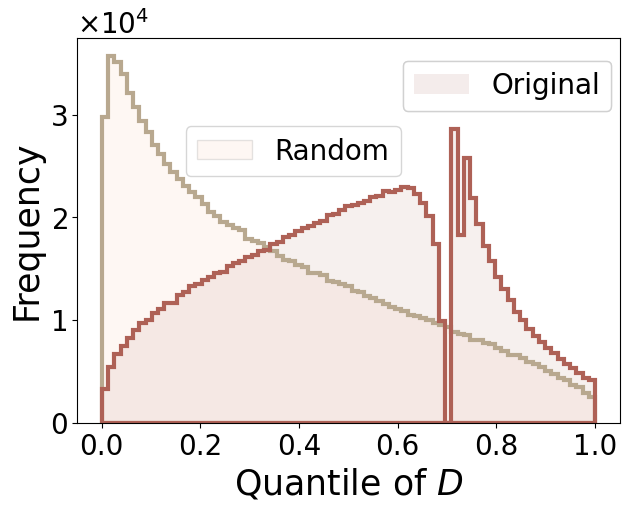

In [29]:
bins = np.linspace(0,1,80)




original_color = '#A96D61'
original_color2 = '#802c7f'
original_line_color2 = '#795e68'
original_line_color = '#AE6156'

plot_difference_histograms(
    dataframe=Review_df,
    column1='PCNT_RANK_original_1960_2019/random1_disruption',
    column2='PCNT_RANK_original_1960_2019_disruption',
    bins=bins,
    label1='Random',
    label2='Original',
    color1='#fab48a',
    color2=original_color,
    edgecolor1='#b8a88f',
    edgecolor2=original_line_color,
    xlabel='Quantile of $D$',
    ylabel='Frequency',
    legend_loc=[(0.2, 0.64),(0.6, 0.81) ],
    figsize=(7, 5),
    
    output_path='../results/Figures/Supplementary_Information/SI_Figure3_Review_WOS_D.png'
)




<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_206743/3043072656.py:16: SyntaxWarning: invalid escape sequence '\D'
  xlabel='Quantile of $\Delta$',


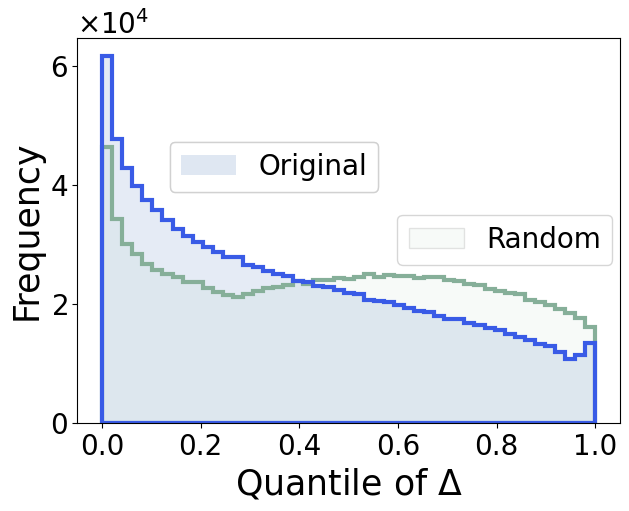

In [38]:
bins = np.linspace(0,1,50)



plot_difference_histograms(
    dataframe=Review_df ,
    column1='PCNT_RANK_original_1960_2019/random1_100_5_q_1_ep_1_bs_65536_embedding_distance',
    column2='PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance',
    bins=bins,
    label1='Random',
    label2='Original',
    color1='#b3d4c1',
    color2= '#00429d',
    edgecolor1='#86af99',
    edgecolor2='#395be6',
    xlabel='Quantile of $\Delta$',
    
    ylabel='Frequency',
    figsize=(7, 5),
    legend_loc = [(0.59, 0.41),(0.17, 0.6)],
    output_path='../results/Figures/Supplementary_Information/SI_Figure3_Review_WOS_EDM.png'
)
   

### Top 30 papers having the largest discrepancy between $D$ and $\Delta$ in Nobel Prize

In [40]:
nobel_prize_df['discrepancy'] = abs(
    nobel_prize_df['PCNT_RANK_original_1960_2019_disruption'] - 
    nobel_prize_df['PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance']
)


highest_discrepancy_rows = nobel_prize_df.sort_values(by='discrepancy', ascending=False)[
    ['title', 'woscode','year', 'paper_id','author_name', 'PCNT_RANK_original_1960_2019_disruption', 
     'PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance']
]

In [41]:
highest_discrepancy_rows[:10]

,title,woscode,year,paper_id,author_name,PCNT_RANK_original_1960_2019_disruption,PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance
647754,SELF-CONSISTENT EQUATIONS INCLUDING EXCHANGE A...,WOS:A19657000000015,1965,38674501,"['KOHN, W', 'SHAM, LJ']",0.001292,0.959290
498784,BROKEN SYMMETRIES + MASSES OF GAUGE BOSONS,WOS:A19641665C00004,1964,38406770,"['HIGGS, PW']",0.000795,0.958504
3290079,DISCOVERY OF A NARROW RESONANCE IN E+E- ANNIHI...,WOS:A1974U764200013,1974,41161713,"['AUGUSTIN, JE', 'BOYARSKI, AM', 'BREIDENBACH,...",0.000054,0.952184
1916698,VIRAL RNA-DEPENDENT DNA POLYMERASE - RNA-DEPEN...,WOS:A1970G643200023,1970,39772403,"['BALTIMORE, D']",0.000199,0.946819
1813197,VIRAL RNA-DEPENDENT DNA POLYMERASE - RNA-DEPEN...,WOS:A1970G643200024,1970,39772404,"['TEMIN, HM', 'MIZUTANI, S']",0.000218,0.944747
1063936,A MODEL OF LEPTONS,WOS:A1967A179700017,1967,39089597,"['WEINBERG, S']",0.013082,0.956207
2865146,ULTRAVIOLET BEHAVIOR OF NON-ABELIAN GAUGE THEO...,WOS:A1973P914500020,1973,40676315,"['GROSS, DJ', 'WILCZEK, F']",0.004041,0.946312
2881922,RELIABLE PERTURBATIVE RESULTS FOR STRONG INTER...,WOS:A1973P914500021,1973,40676316,"['POLITZER, HD']",0.001795,0.941860
1503801,HIGH-ENERGY INELASTIC E-P SCATTERING AT 6 DEGR...,WOS:A1969E345000010,1969,39572709,"['BLOOM, ED', 'COWARD, DH', 'DESTAEBLER, H', '...",0.013238,0.950486
1735293,OBSERVED BEHAVIOR OF HIGHLY INELASTIC ELECTRON...,WOS:A1969E345000011,1969,39572710,"['BREIDENBACH, M', 'FRIEDMAN, JI', 'KENDALL, H...",0.005182,0.942232


In [257]:
# highest_discrepancy_rows[:30].to_csv('../results/Simultaneous_Discoveries/Nobel_Prize_Biggest_Difference_EDM_D.csv')

## Disruption Index for Simultaneous Discovery Papers Without Cross-Citations

In [251]:
# Simultaneous Disruption List

Higgs_Mechanism_wos = {'WOS:A19641665C00004',  # Higgs
                       'WOS:A19641683C00003'  # Engler
                      }

qcd_wos = {'WOS:A1973P914500020',  # Gross
            'WOS:A1973P914500021'  # Politzer
                      }


new_quark_wos = {'WOS:A1974U764200013', #Augustin
        'WOS:A1974U764200012' # Aubert
       }

inelastic_scattering_wos = {'WOS:A1969E345000011', #BREIDENBACH
        'WOS:A1969E345000010' # Bloom
       }

reverse_wos = {'WOS:A1970G643200023', #Baltimore
        'WOS:A1970G643200024' # Temin
       }

Heck_reaction_wos = {'WOS:A1971I769300072', 
                     'WOS:A1972M962500024'}

In [170]:
def getting_d_without_cite(paper_1, paper_2,net_whole):
    n_i, n_j, n_k = set(),set(),set()
    references = np.where(net_whole[paper_1].toarray()!=0)[1]
    citations = np.where(net_whole[:,paper_1].toarray()!=0)[0]
    
    set_reference = set(references)
    set_reference.remove(paper_2)
    
    for c in tqdm(citations):
        refereces_of_citations = np.where(net_whole[c].toarray()!=0)[1]
        
        if set(refereces_of_citations) & set_reference:
            n_j.add(c)
        else:
            n_i.add(c)
            
    for r in tqdm(set_reference):
        citations_of_reference = np.where(net_whole[:,r].toarray()!=0)[0]
        
        for k in citations_of_reference:
            if k not in n_j:
                n_k.add(k)
            elif k in n_i:
                print("error")
                
    return (len(n_i) - len(n_j))/(len(n_i)+len(n_j)+len(n_k))
        
        
            
        
    

In [245]:
NETWORKS_NAME = ['original_1960_2019',]
MEASURE = ['disruption','100_5_q_1_ep_1_bs_65536_embedding/distance']


for net in tqdm(NETWORKS_NAME):
    for m in MEASURE:
        papers_df_whole = load_disruption_distance(papers_df_whole ,net,m)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:55<00:00, 55.20s/it]


## Higgs Case

In [ ]:
net_whole = scipy.sparse.load_npz("/data/sg/munjkim/wos/original_1960_2019/citation_net.npz")

In [139]:
Higgs_Mechanism_wos

{'WOS:A19641665C00004', 'WOS:A19641683C00003'}

In [140]:
nobel_prize_df[nobel_prize_df['woscode'].apply(lambda x: x in Higgs_Mechanism_wos)][['title','author_name','paper_id','original_1960_2019_disruption','PCNT_RANK_original_1960_2019_disruption']]

,title,author_name,paper_id,original_1960_2019_disruption,PCNT_RANK_original_1960_2019_disruption
498784,BROKEN SYMMETRIES + MASSES OF GAUGE BOSONS,"['HIGGS, PW']",38406770,-0.267182,0.000795
587371,BROKEN SYMMETRY + MASS OF GAUGE VECTOR MESONS,"['ENGLERT, F', 'BROUT, R']",38407010,0.152445,0.975996


In [141]:
disruption_without_cite = getting_d_without_cite( 38406770,38407010,net_whole)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.56s/it]


In [142]:
disruption_without_cite

0.28002654280026545

In [143]:
print("Without the cross citation, Higgs paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, Higgs paper has the disruption index with the percentile 98.66770829692987


### qcd

In [144]:
nobel_prize_df[nobel_prize_df['woscode'].apply(lambda x: x in qcd_wos)][['title','author_name','paper_id','original_1960_2019_disruption','PCNT_RANK_original_1960_2019_disruption']]

,title,author_name,paper_id,original_1960_2019_disruption,PCNT_RANK_original_1960_2019_disruption
2865146,ULTRAVIOLET BEHAVIOR OF NON-ABELIAN GAUGE THEO...,"['GROSS, DJ', 'WILCZEK, F']",40676315,-0.121263,0.004041
2881922,RELIABLE PERTURBATIVE RESULTS FOR STRONG INTER...,"['POLITZER, HD']",40676316,-0.184151,0.001795


In [145]:
disruption_without_cite = getting_d_without_cite( 40676315,40676316,net_whole)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.61s/it]


In [146]:
disruption_without_cite

0.05212868892114175

In [147]:
print("Without the cross citation, Gross paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, Gross paper has the disruption index with the percentile 94.88088054747031


In [148]:
disruption_without_cite = getting_d_without_cite( 40676316,40676315,net_whole)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.61s/it]


In [149]:
disruption_without_cite

0.14480899711869133

In [150]:
print("Without the cross citation, POLITZER paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, POLITZER paper has the disruption index with the percentile 97.49628415292695


### new_quark

In [173]:
nobel_prize_df[nobel_prize_df['woscode'].apply(lambda x: x in new_quark_wos)][['title','author_name','paper_id','PCNT_RANK_original_1960_2019_disruption','original_1960_2019_disruption']]


,title,author_name,paper_id,PCNT_RANK_original_1960_2019_disruption,original_1960_2019_disruption
3152346,EXPERIMENTAL OBSERVATION OF A HEAVY PARTICLE-J,"['AUBERT, JJ', 'BECKER, U', 'BIGGS, PJ', 'BURG...",41161712,0.004621,-0.113001
3290079,DISCOVERY OF A NARROW RESONANCE IN E+E- ANNIHI...,"['AUGUSTIN, JE', 'BOYARSKI, AM', 'BREIDENBACH,...",41161713,0.000054,-0.646082


In [152]:
disruption_without_cite =  getting_d_without_cite(41161712,41161713,net_whole)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.61s/it]


In [153]:
disruption_without_cite

0.08525925038917495

In [154]:
print("Without the cross citation, Aubert paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, Aubert paper has the disruption index with the percentile 96.27151780029459


In [155]:
disruption_without_cite =  getting_d_without_cite(41161713,41161712,net_whole)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.61s/it]


In [156]:
disruption_without_cite

0.8022813688212928

In [157]:
print("Without the cross citation, Augustin paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, Augustin paper has the disruption index with the percentile 99.87521650331786


### inelastic_scattering

In [172]:
nobel_prize_df[nobel_prize_df['woscode'].apply(lambda x: x in inelastic_scattering_wos)][['title','author_name','paper_id','original_1960_2019_disruption','PCNT_RANK_original_1960_2019_disruption']]

,title,author_name,paper_id,original_1960_2019_disruption,PCNT_RANK_original_1960_2019_disruption
1503801,HIGH-ENERGY INELASTIC E-P SCATTERING AT 6 DEGR...,"['BLOOM, ED', 'COWARD, DH', 'DESTAEBLER, H', '...",39572709,-0.061805,0.013238
1735293,OBSERVED BEHAVIOR OF HIGHLY INELASTIC ELECTRON...,"['BREIDENBACH, M', 'FRIEDMAN, JI', 'KENDALL, H...",39572710,-0.106145,0.005182


In [159]:
disruption_without_cite = getting_d_without_cite( 39572709,39572710,net_whole)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:23<00:00,  2.59s/it]


In [160]:
disruption_without_cite

0.2191780821917808

In [161]:
print("Without the cross citation, Bloom paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, Bloom paper has the disruption index with the percentile 98.27132873823216


In [171]:
disruption_without_cite = getting_d_without_cite( 39572710,39572709,net_whole)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:40<00:00,  2.54s/it]


In [169]:
disruption_without_cite

-0.02554594149155336

In [166]:
print("Without the cross citation, BREIDENBACH paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, BREIDENBACH paper has the disruption index with the percentile 4.941306456038401


### Reverse Transcriptase

In [167]:
nobel_prize_df[nobel_prize_df['woscode'].apply(lambda x: x in reverse_wos)][['title','author_name','paper_id','PCNT_RANK_original_1960_2019_disruption']]

,title,author_name,paper_id,PCNT_RANK_original_1960_2019_disruption
1813197,VIRAL RNA-DEPENDENT DNA POLYMERASE - RNA-DEPEN...,"['TEMIN, HM', 'MIZUTANI, S']",39772404,0.000218
1916698,VIRAL RNA-DEPENDENT DNA POLYMERASE - RNA-DEPEN...,"['BALTIMORE, D']",39772403,0.000199


In [174]:
disruption_without_cite = getting_d_without_cite( 39772404,39772403	,net_whole)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:35<00:00,  2.54s/it]


In [175]:
disruption_without_cite

0.4280328992460589

In [177]:
print("Without the cross citation, TEMIN paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, TEMIN paper has the disruption index with the percentile 99.23820328160862


In [178]:
disruption_without_cite = getting_d_without_cite( 39772403,39772404	,net_whole)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:30<00:00,  2.51s/it]


In [181]:
disruption_without_cite

0.4886943836615609

In [182]:
print("Without the cross citation, BALTIMORE paper has the disruption index with the percentile", stats.percentileofscore(papers_df['original_1960_2019_disruption'], disruption_without_cite))

Without the cross citation, BALTIMORE paper has the disruption index with the percentile 99.39449853062773


### Heck Reaction

In [254]:
papers_df_whole[papers_df_whole['woscode'].apply(lambda x: x in Heck_reaction_wos)][['title','author_name','paper_id','PCNT_RANK_original_1960_2019_disruption','PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance']]

,title,author_name,paper_id,PCNT_RANK_original_1960_2019_disruption,PCNT_RANK_original_1960_2019_100_5_q_1_ep_1_bs_65536_embedding_distance
2019721,ARYLATION OF OLEFIN WITH ARYL IODIDE CATALYZED...,"['MIZOROKI, T', 'MORI, K', 'OZAKI, A']",39974287,0.911139,0.663936
2443918,PALLADIUM-CATALYZED VINYLIC HYDROGEN SUBSTITUT...,"['HECK, RF', 'NOLLEY, JP']",40377282,0.008268,0.641946


In [242]:
disruption_without_cite = getting_d_without_cite( 40377282,39974287,net_whole)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.55s/it]


In [244]:
disruption_without_cite

0.43867243867243866